## Neuron example - 2+ delays

In this example the delay differential equation (DDE) system is used to model the interaction between two neurons, x₁ and x₂. The DDE system is given by:
```math
\begin{align}
  \dot{x}_1&= -\kappa x_1(t) + \beta \tanh(x_1(t-\tau_s)) + a_{12} \tanh(x_2(t-\tau_2))\\
  \dot{x}_2&=-\kappa x_2(t) + \beta \tanh(x_2(t-\tau_s)) + a_{21} \tanh(x_2(t-\tau_1))
\end{align}
```
where τ₁ and τ₂ are the delays between neurons 1 and 2 and where τ_s is the delay between each neuron getting a stimulus and reacting to the stimulus.

The following packages and functions are needed:

In [27]:
using CairoMakie
using LinearAlgebra
include("neuronfunc.jl") #system of neuron example
include("neurontau.jl") #Delay forumla for neuron example
include("../shared/f_deriv.jl") #used to find state and/or parameter derivatives
include("../shared/jacobian_new.jl") #Jacobian function
include("../shared/newton_new.jl") #Newton function
include("../shared/create_ststfunc.jl") #Initialisates a function to find equilibria 
include("../shared/track_curve_new.jl") #Tracking curve function (used for continuation and equilibria branches)
include("../shared/stab_func_matrix.jl")#uses large matrix method to find stability and eigenvalues (and eigenvector and ω is interested in Hopf bifurcation)
include("../shared/create_hopffunc.jl")#finds initial guess for Hopf information and creates a function that can find the true Hopf values

create_hopffunc (generic function with 1 method)

In [28]:
#Values of parameters (same as those given in the neuron demo for DDE-Biftool)
k=0.5
beta=-1
a12=1
a21=2.34 
tau1=0.2
tau2=0.2
taus=1.5

nd=3 #there are 3 delays
y01,feq=create_ststfunc(neuronfunc,[0.0,0],[k,beta,a12,a21,tau1,tau2,taus], nd, par_indx=4)#varying paramter a21 so parameter index is 4
#The above outputs an initial equilibirium and a function to find the equilibria

([0.0, 0.0, 2.34], var"#f_equilibrium#161"{Int64, typeof(neuronfunc), Vector{Float64}, Int64, Int64}(4, Main.neuronfunc, [0.5, -1.0, 1.0, 2.34, 0.2, 0.2, 1.5], 3, 2))

In [29]:
#check equilibrium (f(x*,...,x*)=0)
xvec=[fill(0.0,2) for _ in 1:nd+1]
neuronfunc(xvec,[k,beta,a12,a21,tau1,tau2,taus])

2-element Vector{Float64}:
 0.0
 0.0

# Equilibria branch and stability

Finding the stability of equilibiria of DDEs is more complex than finding the stability of equilibria of ODEs due to the infinite dimensional past. For this example the stability was found by using a large matrix that can be used to create a finite-dimensional system that can approximate the stability of the equilibria. The function ``` stab_func_matrix ``` has a first output of 1 is the equilibrium point if stable and has 0 if it is unstable. Below we find the stability of one equilibrium point:

In [30]:
#Test stability of initial point (it should be unstable)
x0=y01[1:2]
p0=y01[3]
stabi,eigvalsi,eigvecs1=stab_func_matrix(neuronfunc,neurontau,x0,[p0],[k,beta,a12,a21,tau1,tau2,taus],[4],nd,doprint=1)
unstabindx=findfirst(isequal(1),real(eigvalsi).>0)
unstabeigi=eigvalsi[unstabindx]

println("The stability is: $stabi")
println("The eigenvalues are: $eigvalsi")
println("The unstable eigenvalue $unstabeigi") #this values seems to match that given in DDE-Biftool example

The stability is: 0
The eigenvalues are: ComplexF64[-968.7660348034071 + 0.0im, -968.5375195436628 - 14.653396899307069im, -968.5375195436628 + 14.653396899307069im, -967.8521945592739 - 29.292579296872145im, -967.8521945592739 + 29.292579296872145im, -966.710722020216 - 43.903346422597444im, -966.710722020216 + 43.903346422597444im, -965.1142048297761 - 58.47152495663181im, -965.1142048297761 + 58.47152495663181im, -963.0641855544266 - 72.9829827208269im, -963.0641855544266 + 72.9829827208269im, -960.5626449278141 - 87.42364233091526im, -960.5626449278141 + 87.42364233091526im, -957.6119999296247 - 101.77949479477547im, -957.6119999296247 + 101.77949479477547im, -954.2151014409508 - 116.03661304497504im, -954.2151014409508 + 116.03661304497504im, -950.3752314791366 - 130.1811653914015im, -950.3752314791366 + 130.1811653914015im, -946.0961000139373 - 144.19942888147452im, -946.0961000139373 + 144.19942888147452im, -941.381841368752 - 158.07780255470982im, -941.381841368752 + 158.077802

We now find the equilibria branch whilst varying the parameter a₂₁ and then find stability of these equilibrium points:

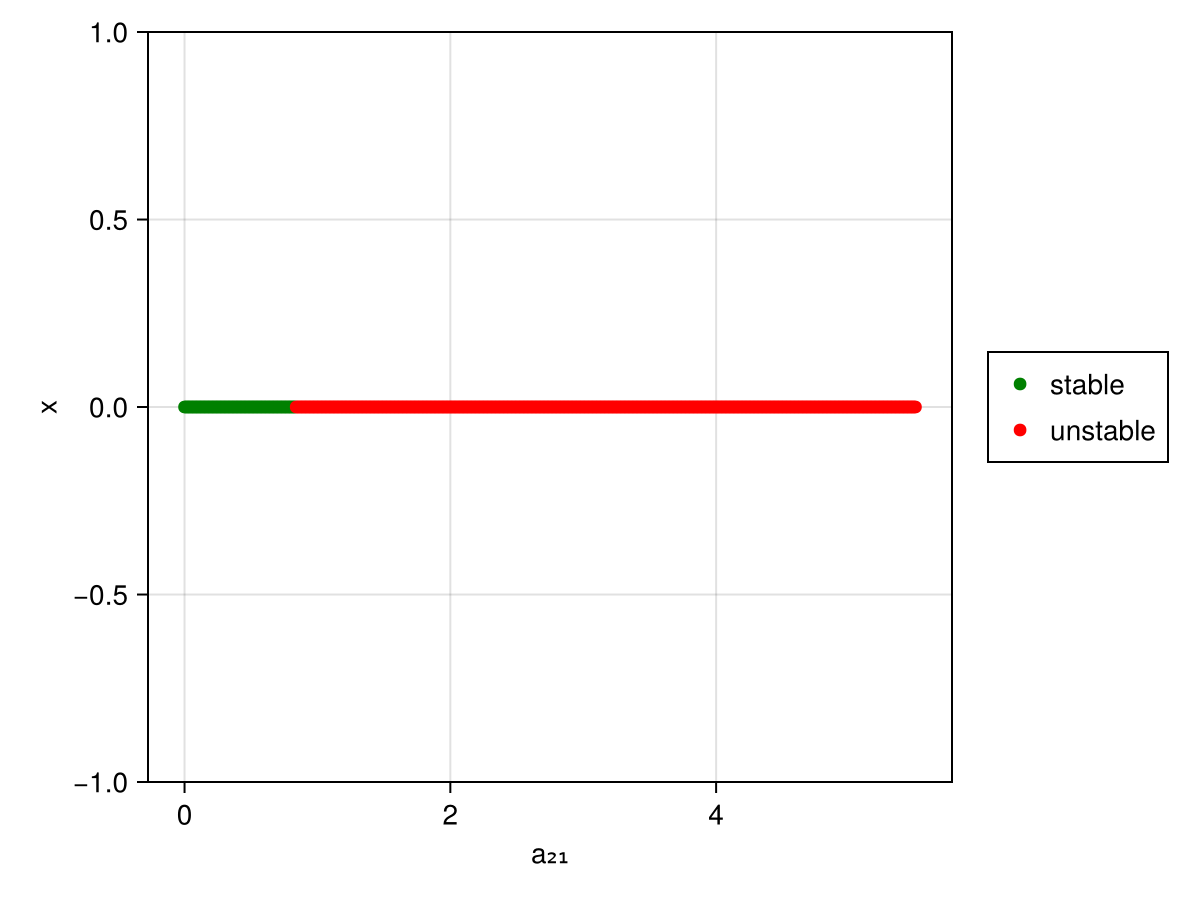

In [31]:
y02,feq2=create_ststfunc(neuronfunc,[0.0,0],[k,beta,a12,0,tau1,tau2,taus], nd, par_indx=4) #we set a21 to 0 and finding starting point for equilibria branching
alist1,ytan1=track_curve_new(feq2,y02,[0.0,0,1],nmax=550)#tracks equilibria to give equilibria branch

xmat1=hcat([u[1] for u in alist1],[u[2] for u in alist1]) #finds the values of x1 and x2 for the equilibria
xlist1=[xmat1[i,:] for i in 1:size(xmat1,1)] #creates a vector of vectors of all the equilibria points


plist1=[u[3] for u in alist1] #A vector of the values of a21 for the equilibria points

m=100 #number of discretised steps
n=2 #number of states (x1,x2)
neq=length(plist1) #number of equilibrium points we're finding the stability of
stab=fill(NaN,neq)
eigvals1=[fill(0.0+0.0*im,n*(1+nd*m)) for _ in 1:neq]

for i in 1:neq
    stab[i],eigvals1[i],=stab_func_matrix(neuronfunc,neurontau,xlist1[i],[plist1[i]],[k,beta,a12,a21,tau1,tau2,taus],[4],nd,doprint=1,m=m) #outputs the stability (1 for stable, 0 for unstable) and also gives the eigenvalues for each point
end

stable=(stab.==1.0) #highlights indices of stable points (indicated by a 1 in stable vector)
unstable=(stab.==0.0)#highlights indices of unstable points (indicated by a 1 in unstable vector)

#Below plots the equilibria and shows their stability
fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="a₂₁",ylabel="x")
scatter!(ax1,plist1[stable],[u[1] for u in xlist1[stable]],label="stable",color="green")
scatter!(ax1,plist1[unstable],[u[1] for u in xlist1[unstable]],label="unstable",color="red")
Legend(fig1[1,2], ax1, merge=true)
fig1

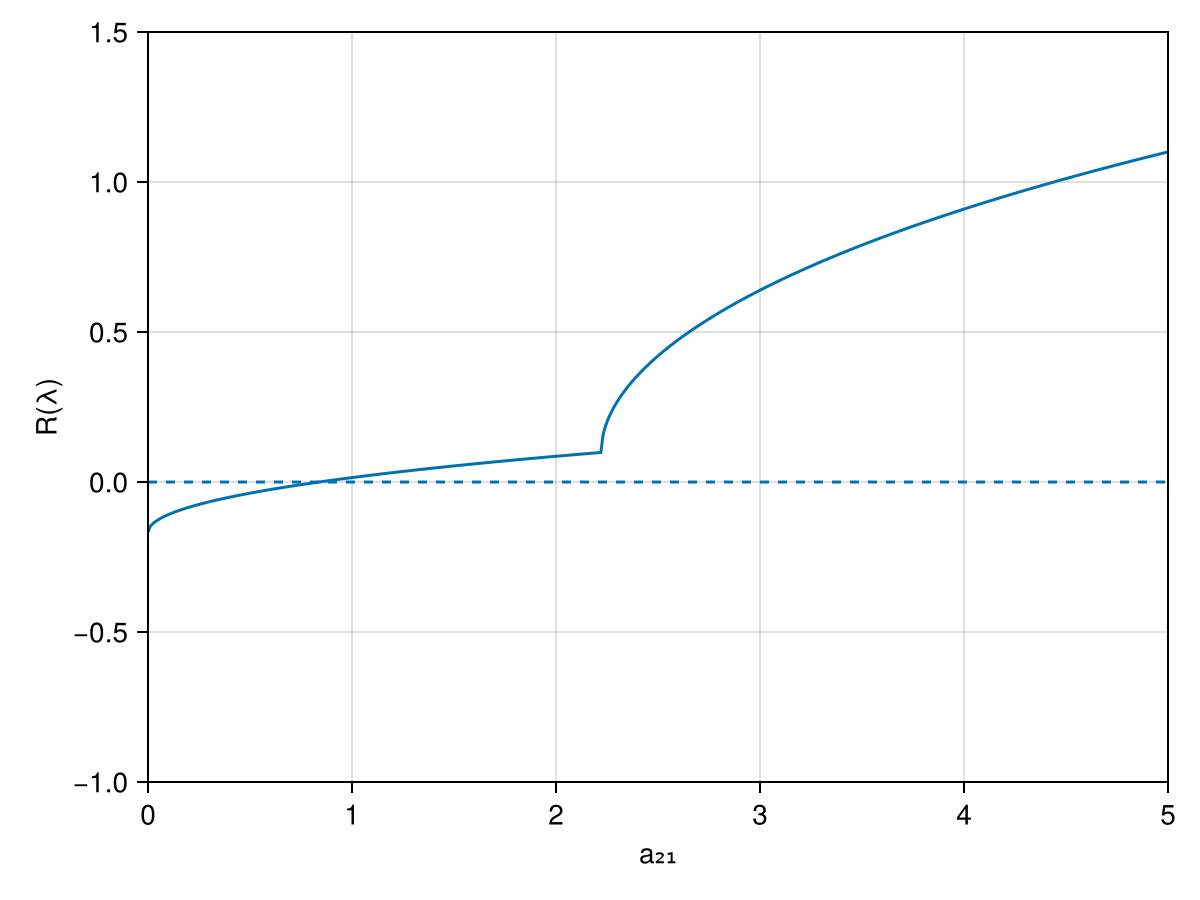

In [32]:
avals=[u[3] for u in alist1] #list of a21  values
realeigs=real(eigvals1) #gets real parts of all eigenvalues for each tracked point
n_eig=length(avals) #number of equilibrium points

maxrealeigs=fill(NaN,n_eig)

for i in 1:n_eig
    realindx=argmax(realeigs[i]) #finds index of largest real part of eigenvalues for a21 value
    maxrealeigs[i]=realeigs[i][realindx] #the largest real part of eigenvalues for the a21 value (needed as largest real part dictates if a point is stable (<0) or unstable (>0))
end

#Below plots the largest real eigenvalue part for varying parameter a21
fig2=Figure()
ax2=Axis(fig2[1,1],xlabel="a₂₁",ylabel="R(λ)")
lines!(ax2,avals,maxrealeigs)
xlims!(ax2,[0.0,5])
ylims!(ax2,[-1,1.5])
hlines!(ax2,0,linestyle=:dash) #horiztonal line at R(λ)=0 to indicate imagainary axis
fig2

# Hopf bifurcation

The eigenvalues of the linearised system determine the equilibrium's stability. A Hopf bifurcation occurs when the stability behaviour changes and a pair of complex conugate eigenvalues of the linearised system crosses the imaginary axis and become purely imaginary, i.e. λ=±ωi. We start finding the Hopf parameters by finding the initial guess of the a₂₁ value for the Hopf bifurcation: 

In [33]:
#We aim to find where the eigenvalues cross the imaginary axis (and become purely imaginary )
unstab_indx=findfirst(isequal(0.0),stab) #find index of stability change
a21unstab=avals[unstab_indx] #initial guess of a21 value for Hopf bifurcation

0.8400000000000005

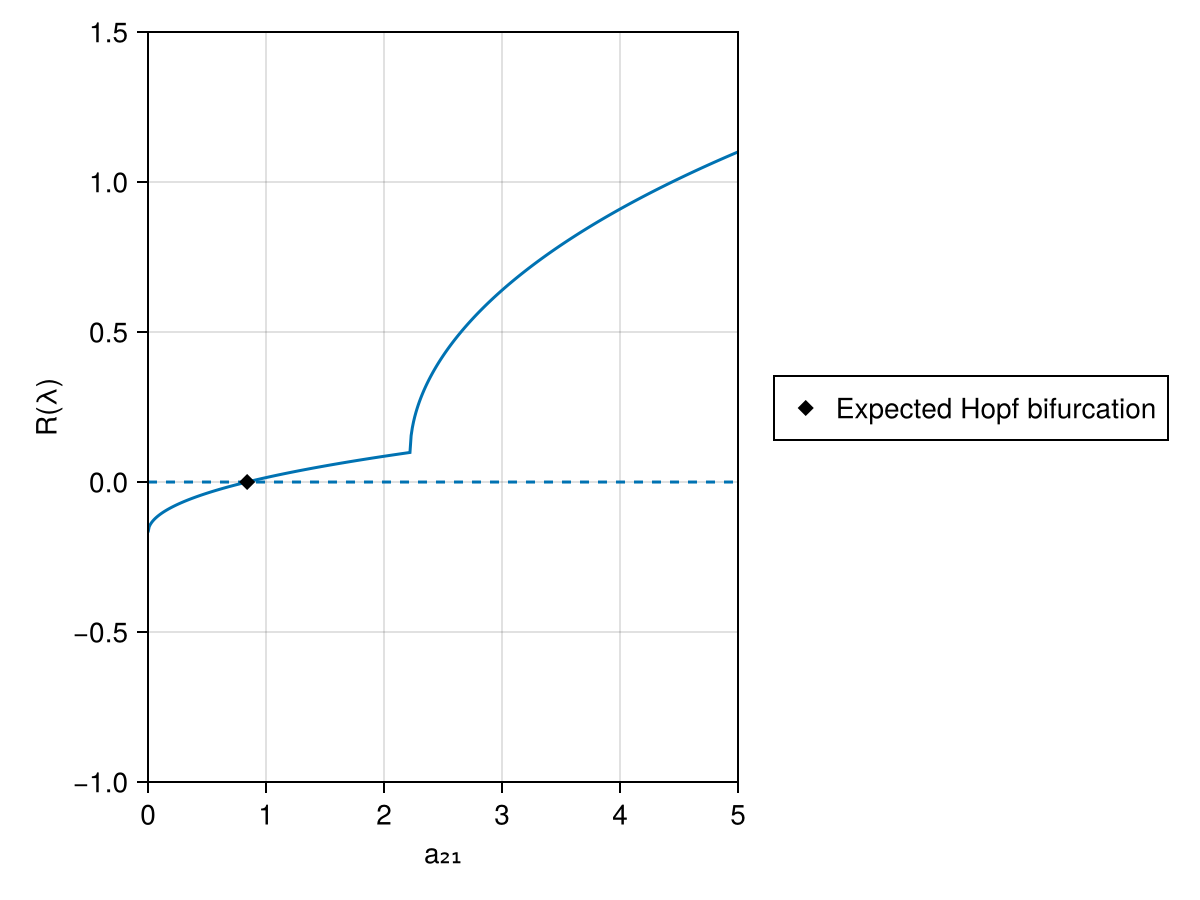

In [34]:
#Below plots Figure 2 but with the suspected Hopf bifurcation values plotted as well
fig3=Figure()
ax3=Axis(fig3[1,1],xlabel="a₂₁",ylabel="R(λ)")
lines!(ax3,avals,maxrealeigs)
xlims!(ax3,[0.0,5])
ylims!(ax3,[-1,1.5])
hlines!(ax3,0,linestyle=:dash) #horiztonal line at R(λ)=0 to indicate imagainary axis
scatter!(ax3,a21unstab,maxrealeigs[unstab_indx],color=:black,marker=:diamond, label="Expected Hopf bifurcation")
Legend(fig3[1,2], ax3, merge=true)
fig3

Now we have an initial guess for the Hopf parameters we find the true parameter values:

In [35]:
yh01,fhopf=create_hopffunc(neuronfunc,neurontau,[k,beta,a12,0,tau1,tau2,taus],xlist1[unstab_indx],[a21unstab],[4],nd) #outputs initial guess of the Hopf bifurcation (including x, ω and a21 estimates) and a function that contians the method/formula to find the Hopf bifurcation
println("The initial guess for Hopf info: $yh01")
println("The initial guess for Hopf info: $yh01")
yh1,conv1,=newton_new(fhopf,yh01) #putting initial guess and Hopf function into newton we get the true parameter values and information for the Hopf bifurcation
println("The true information for the Hopf bifurcation: $yh1")
println("converged?: $conv1")
a_hopf=yh1[end]
om_hopf=yh1[end-1]
x_hopf=yh1[1:2]
println("The ω value for hopf bifurcation: $om_hopf")
println("The a21 value for hopf bifurcation: $a_hopf")

The initial guess for Hopf info: [0.0, 0.0, -0.7372097807744674, -0.675663924692196, 0.0, -3.0561185176617133e-14, 0.7668092696642693, 0.8400000000000005]
The initial guess for Hopf info: [0.0, 0.0, -0.7372097807744674, -0.675663924692196, 0.0, -3.0561185176617133e-14, 0.7668092696642693, 0.8400000000000005]
The true information for the Hopf bifurcation: [0.0, 0.0, -0.7438855391134426, -0.6683070437290805, -1.5196126276112554e-14, -1.3648090508619166e-14, 0.7819651620459528, 0.8071232251830747]
converged?: true
The ω value for hopf bifurcation: 0.7819651620459528
The a21 value for hopf bifurcation: 0.8071232251830747


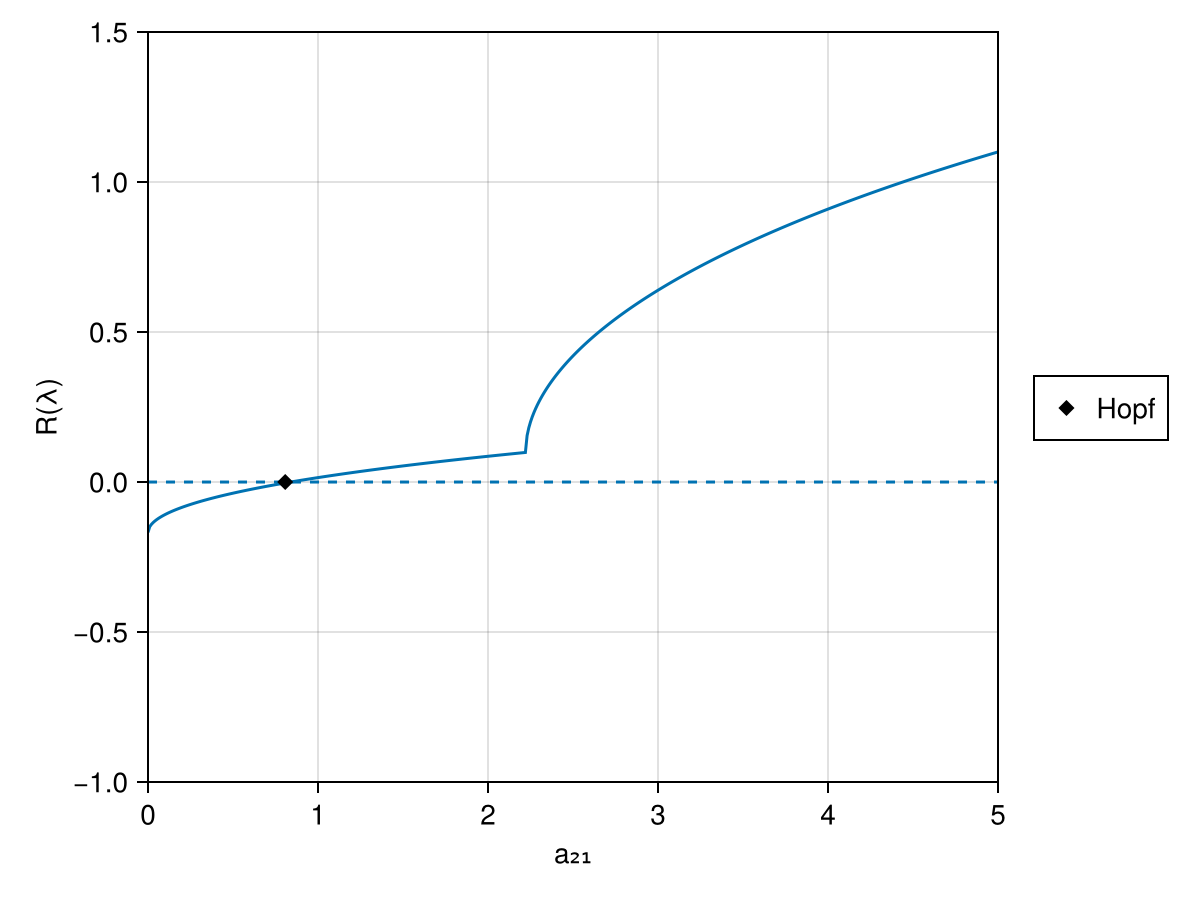

In [36]:
#Below plots Figure 2 but with the true Hopf bifurcation values plotted as well
fig4=Figure()
ax4=Axis(fig4[1,1],xlabel="a₂₁",ylabel="R(λ)")
lines!(ax4,avals,maxrealeigs)
xlims!(ax4,[0.0,5])
ylims!(ax4,[-1,1.5])
hlines!(ax4,0,linestyle=:dash) #horiztonal line at R(λ)=0 to indicate imagainary axis
scatter!(ax4,a_hopf,0,color=:black,marker=:diamond, label="Hopf") #true value of Hopf plotted at a=a_hopf and R(λ)=0
Legend(fig4[1,2], ax4, merge=true)
fig4

# Stability using barycentric interpolation

The function ```stab_func_bi``` uses barycentric interpolation to find the stability and the rightmost eigenvalue of an equilibrium point.

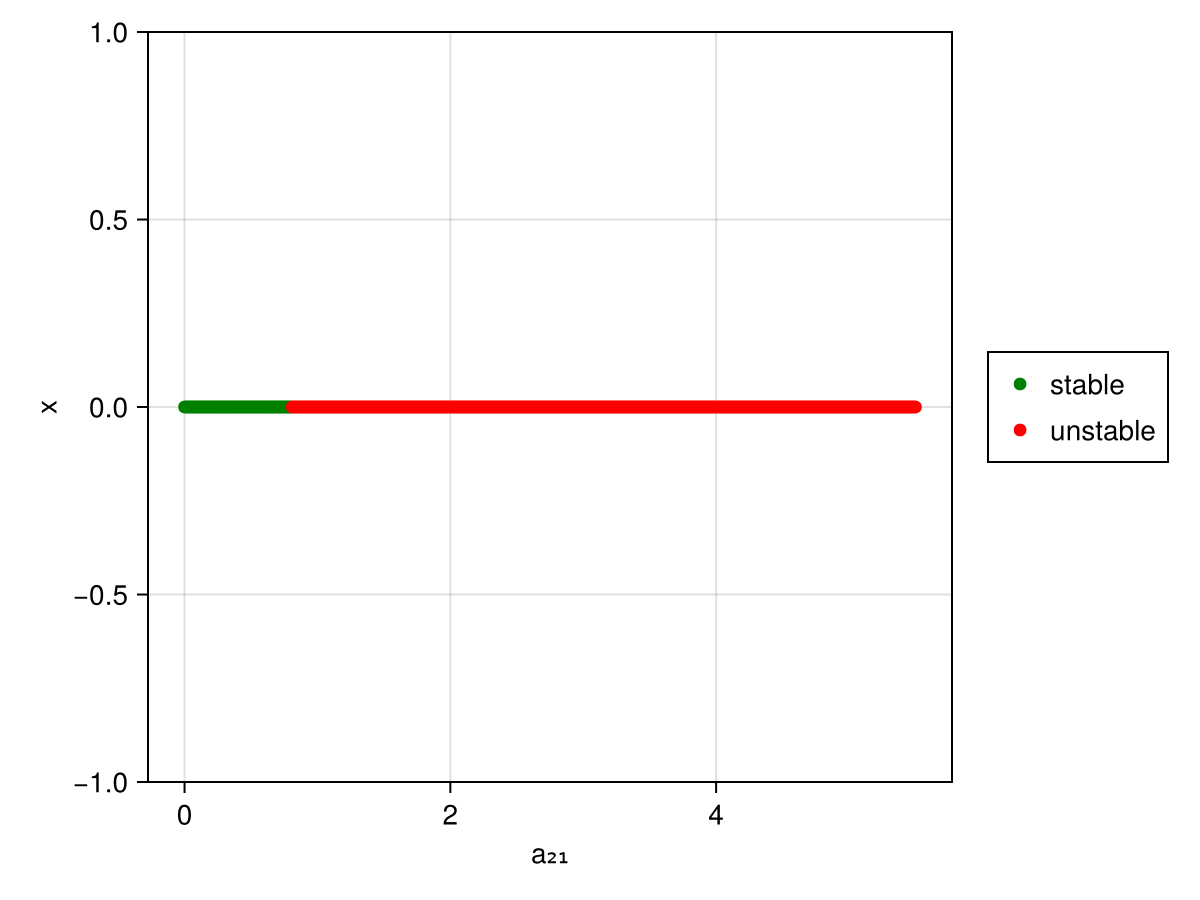

In [37]:
include("../stab_func_bi.jl")
include("../j_eval.jl")
#include("../shared/stab_func_bi.jl")
#include("../shared/j_eval.jl")

neq=length(plist1) #number of equilibrium points we're finding the stability of
stab_bi=fill(NaN,neq)
lamr1=fill(0.0+0.0*im,neq)

for i in 1:neq
    stab_bi[i],lamr1[i],=stab_func_bi(neuronfunc,neurontau,[k,beta,a12,plist1[i],tau1,tau2,taus],xlist1[i],nd,20) #outputs the stability (1 for stable, 0 for unstable) and also gives the rightmost eigenvalue for each equilibrium point
end

stablebi=(stab_bi.==1.0) #highlights indices of stable points (indicated by a 1 in stable vector)
unstablebi=(stab_bi.==0.0)#highlights indices of unstable points (indicated by a 1 in unstable vector)

#Below plots the equilibria and shows their stability
fig5=Figure()
ax5=Axis(fig5[1,1],xlabel="a₂₁",ylabel="x")
scatter!(ax5,plist1[stablebi],[u[1] for u in xlist1[stablebi]],label="stable",color="green")
scatter!(ax5,plist1[unstablebi],[u[1] for u in xlist1[unstablebi]],label="unstable",color="red")
Legend(fig5[1,2], ax5, merge=true)
fig5

In [38]:
unstab_biindx=findfirst(isequal(0.0),stab_bi) #finds index of Hopf bifurcation
a21unstabbi=plist1[unstab_biindx] #finds initial guess for parameter a21 value for a Hopf bifurcation

println("The estimated a21 value for Hopf bifurcation using large matrix stability (stab_func_matrix) is: $a21unstab")
println("The estimated a21 value for Hopf bifurcation using  barycentric interpolation stability (stab_func_bi) is: $a21unstabbi")
println("True Hopf a21 value is: $a_hopf")

The estimated a21 value for Hopf bifurcation using large matrix stability (stab_func_matrix) is: 0.8400000000000005
The estimated a21 value for Hopf bifurcation using  barycentric interpolation stability (stab_func_bi) is: 0.8100000000000005
True Hopf a21 value is: 0.8071232251830747


# Continuation in (a₂₁,τ_s)-plane

We continue the Hopf points in the a₂₁ and τ_s parameter plane:

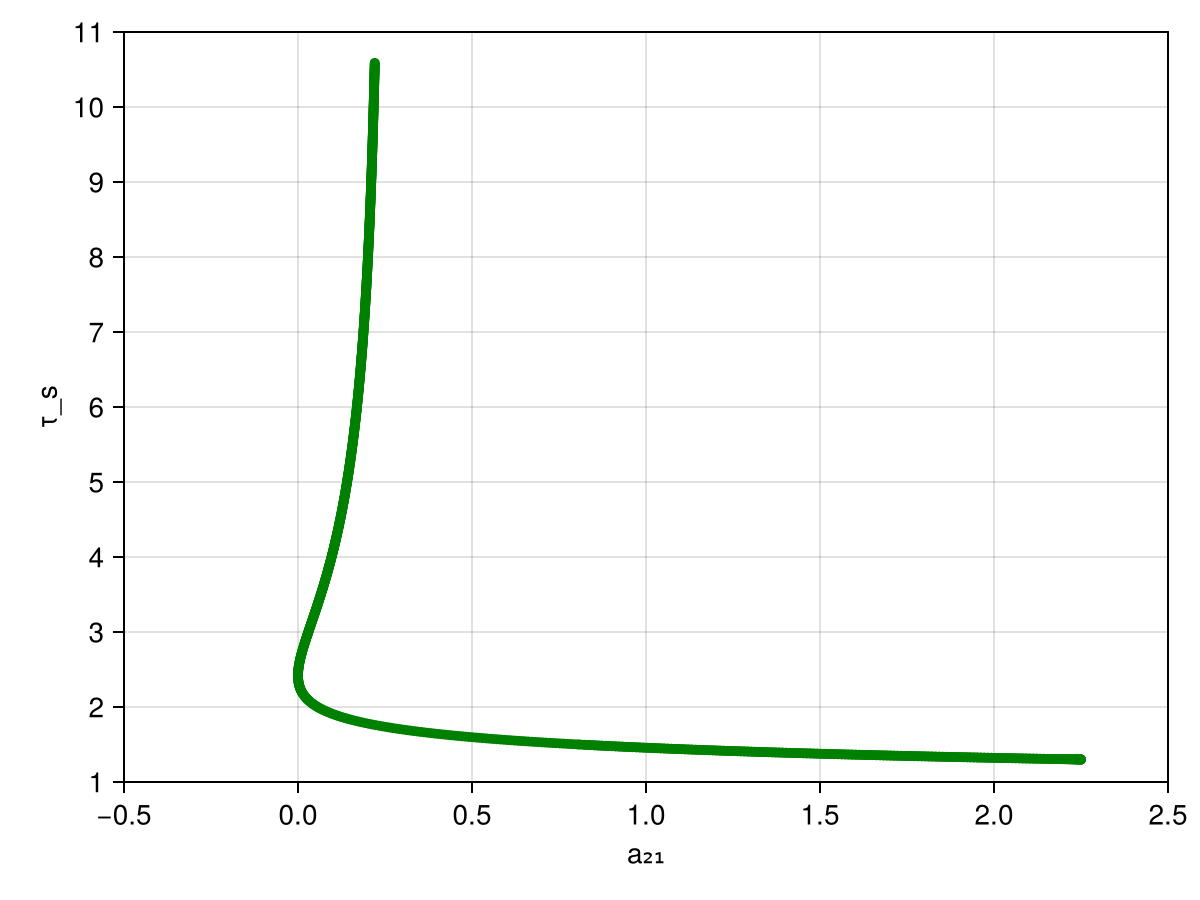

In [39]:
yheq01,fhopfeq1=create_hopffunc(neuronfunc,neurontau,[k,beta,a12,a_hopf,tau1,tau2,taus],x_hopf,[a_hopf,taus],[4,7],nd) #initialises hopf function and initial guess for a21≈0.8 and tau_s=1.5
yheqlist1,heqtan1=track_curve_new(fhopfeq1,yheq01,[0.0,0,0,0,0,0,0,1,-1],nmax=1250) #tracks a21 and tau_s over (a21, tau_s) plane

#Plot of continuation/tracking in (a21,tau_s) plane
fig6=Figure()
ax6=Axis(fig6[1,1],xlabel="a₂₁",ylabel="τ_s")
scatter!(ax6,[u[end-1] for u in yheqlist1],[u[end] for u in yheqlist1],color="green",markersize=:7)
ylims!(ax6,[1,11])
xlims!(ax6,[-0.5,2.5])
ax6.xticks=-0.5:0.5:2.5 #creates x-axis increments that match those given in DDE-Biftool (makes comparsion between the two easier)
ax6.yticks=1:1:11 #creates y-axs increments that match those given in DDE-Biftool
fig6